In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

# Wstęp do (głębokich) modeli generatywnych

Modele generatywne to rodzaj nienadzorowanych algorytmów uczenia maszynowego, co oznacza, że dane nie mają (zazwyczaj) przypisanych etykiet. Na podstawie samych reprezentacji wejściowych będziemy uczyć się rozkładu prawdopodobieństwa danych, co umożliwi nam generowanie nowych przykładów, które są podobne do obserwowanych podczas treningu.

Typowymi przykładami zastosowań modeli generatywnych jest tworzenie obrazów, generowanie tekstu lub projektowanie nowych molekuł. Kilka z najpopularniejszych modeli generatywnych opartych o sieci neuronowe jest przedstawionych poniżej.

1. **Autoenkoder** - model ten składa się z dwóch elementów, enkodera i dekodera. Enkoder przyjmuje reprezentację wejściową danych i przekształca ją w mniej wymiarową reprezentację ukrytą (koduje jako wektor liczb). Dekoder przyjmuje zakodowany wektor i przekształca go z powrotem w obiekt podobny do wejściowego. Mamy więc model $x'=D(E(x))$, a celem optymalizacji będzie minimalizacja różnic między obiektem wejściowym i odtworzonym przez model: $\mathcal{L}=\|x-x' \|_2$. Aby model był generatywny, dodaje się jeszcze dodatkowy warunek, aby przestrzeń ukryta (kodowane wektory) miały rozkład normalny, tj. $\mathcal{L}=\|x-x' \|_2 + \mathcal{L}_{normal}(E(x))$. Wtedy losując wektor $z\sim \mathcal{N}(0, 1)$ i przerzucając go przez dekoder $x'=D(z)$ otrzymamy nowo wygenerowany obiekt.
![](https://upload.wikimedia.org/wikipedia/commons/4/4a/VAE_Basic.png)
3. **Sieć rekurencyjna (modele autoregresyjne)** - rodzaj sieci, której wyjście jest użyte później ponownie jako wejście do sieci. Siecie rekurencyjne generują obiekty element po elemencie, np. tekst znak po znaku albo molekuły atom po atomie. Wygenerowane stany pośrednie są użyte jako wejście modelu i na tej podstawie zapada decyzja, jaki jest kolejny element do wygenerowania.
![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Gated_Recurrent_Unit.svg)

# Jak modele generatywne używane są w projektowaniu leków

Modele generatywne mają dwa główne zastosowania w projektowaniu leków. Możemy generować związki od zera i wtedy mówimy o **projektowaniu leków** *de novo*, albo możemy optymalizować istniejące molekuły, głównie na etapie optymalizacji struktury wiodącej (ang. **lead optimisation**), kiedy mamy już chemię wykazującą aktywność biologiczną, ale chcemy tę aktywność wzmocnić, lub poprawić inne własności związku (ADMET).

Istnieją dwa podstawowe rodzaje generatorów w chemii: te oparte na reprezentacji **SMILES** i te oparte na **grafach molekularnych**. Możemy zatem generować ciąg symboli reprezentacji SMILES, ale pojawiają się podobne problemy jak z przewidywaniem na tej preprezentacji i nie zawsze otrzymujemy poprawne związki (SMILES ma określoną gramatykę). Bardziej naturalnym wydaje się generowanie grafów, ale i to podejście ma swoje problemy:

1. Generowanie sekwencyjne po 1 atomie prowadzi do **niepoprawnych stanów przejściowych**. Na przykład generując pierścień, będziemy mieć wydłużający się łańcuch, który zamknie się w pierścień dopiero na samym końcu. Rozwiązaniem tutaj jest generowanie oparte o fragmenty uwzględniające całe pierścienie zamiast pojedynczych atomów.
2. Grafy molekularne są **strukturami dyskretnymi**, tzn. atomy i połączenia są konkretnie określone, zero-jedynkowe. Nie możemy mieć częściowych wiązań ani mieszanych symboli jednego atomu. W związku z tym reprezentacja ciągła będąca zazwyczaj wyjściem z sieci neuronowej musi zostać zamieniona na reprezentację dyskretną, np. macierz sąsiedztwa musi być zaokrąglona do zer i jedynek, żeby przedstawiała poprawny związek. Przy takiej operacji tracimy różniczkowalność w sieci, gdybyśmy próbowali liczyć funkcję kosztu na wygenerowanym związku. Rozwiązaniem często jest tutaj Gumbel Softmax, który pozwala na różniczkowalne "zaokrąglenia", oraz uczenie ze wzmocnieniem, które nie wymaga różniczkowalności sieci (tam gradienty wyznacza się trochę inaczej, w oparciu o tzw. funkcję nagrody).

Dodatkowym czynnikiem, który musimy wziąć pod uwagę w projektowaniu leków, jest optymalizacja własności molekuły. Oprócz generowania poprawnych związków chcemy, aby struktura była możliwa do zsyntetyzowania i aby miała wszystkie własności niezbędne do bycia lekiem. Dlatego właśnie w proces uczenia (albo generowania) włącza się dodatkowe ograniczenia na tworzone związki.

# Przykład modelu generatywnego na SMILES-ach - ReLeaSE

Kod modelu możemy pobrać do folderu `labs` z repozytorium: https://github.com/isayev/ReLeaSE ([Paper](https://www.science.org/doi/epdf/10.1126/sciadv.aap7885))

**TL;DR**

W tej pracy implementowany jest generatory SMILES. Ponieważ SMILES mają określoną gramatykę i jest to gramatyka bezkontekstowa (powtórka z języków formalnych i automatów), to będzie istniał automat ze stosem, który gramatykę tę akceptuje. Stos jest niezbędny to pamiętania np. otwarcia nawiasu oznaczającego gałąź molekuły oraz otwarcia pierścienia oznaczanego liczbami. Poprzez dodanie stosu do zwykłej sieci rekurencyjnej (np. GRU) jesteśmy w stanie generować więcej poprawnych związków. Dodatkowo własności generowanych związków mogą być optymalizowane przez włączenie do treningu modelu predykcyjnego, który był trenowany do przewidywania danej własności. Model ten użyty jest do policzenia nagrody modelu, gdy wygenerowany zostanie już pełny SMILES. Parametry są poprawiane metodą uczenia ze wzmocnieniem, a konkretnie algorytmem REINFORCE.

In [25]:
sys.path.append('../ReLeaSE/release')

In [ ]:
from stackRNN import StackAugmentedRNN
from data import GeneratorData

use_cuda = False

In [75]:
hidden_size = 50
stack_width = 50
stack_depth = 10
lr = 0.001
optimizer_instance = torch.optim.Adadelta
layer_type = 'GRU'

gen_data_path = '../ReLeaSE/data/logP_labels.csv'
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter=',',
                         cols_to_read=[1], keep_header=False)

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters,
                                 hidden_size=hidden_size,
                                 output_size=gen_data.n_characters,
                                 layer_type=layer_type,
                                 n_layers=1, is_bidirectional=True,
                                 has_stack=True,
                                 stack_width=stack_width,
                                 stack_depth=stack_depth,
                                 use_cuda=use_cuda,
                                 optimizer_instance=optimizer_instance,
                                 lr=lr)
if use_cuda:
    my_generator = my_generator.cuda()

losses = my_generator.fit(gen_data, 1000)

my_generator.evaluate(gen_data)

In [82]:
gen_data_path = '../ReLeaSE/data/chembl_22_clean_1576904_sorted_std_final.smi'
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

model = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=1500,
                                     output_size=gen_data.n_characters, 
                                     layer_type='GRU',
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=1500, stack_depth=10, 
                                     use_cuda=use_cuda)

model.load_model('../ReLeaSE/checkpoints/generator/checkpoint_biggest_rnn')

Random Smile:  Cc1ccc(cc1)N1C(=O)N(Cc2ccccc2)C(=O)c2cc(ccc12)-c1ccccc1


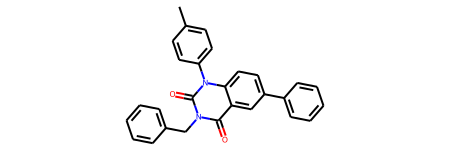

In [88]:
smiles = model.evaluate(gen_data)[1:-1]

print('Random Smile: ', smiles)
mol = Chem.MolFromSmiles(smiles)
if mol:
    display(mol)
else:
    print('Invalid SMILES!')

# Przykład grafowego modelu generatywnego - JT-VAE

Kod modelu możemy pobrać do folderu `labs` z repozytorium: https://github.com/Bibyutatsu/FastJTNNpy3 ([Paper](https://arxiv.org/pdf/1802.04364.pdf))

**TL;DR**

JT-VAE jest modelem typu autoenkoder pracującym na grafach molekularnych. Żeby ułatwić generowanie związków, wzory strukturalne zamieniane są na tzw. junction trees, w których pierścienie zamieniane są na pojedyncze wierzchołki. W ten sposób otrzymujemy strukturę drzewa zamiast grafu, z którego później możemy odkodować pełen związek. Enkoder grafowy jest siecią grafową (MPNN), natomiast enkoder drzewowy jest podobną siecią, ale tym razem możemy przekazywać wiadomości tylko od korzenia do liści. Dekoder drzewowy jest siecią rekurencyjną (GRU), która buduje drzewo w kolejności DFS. Dekoder grafowy służy wyłącznie do odpowiedniego łączenia atomów po zdekodowaniu wierzchołków drzewa - zdekodowane pierścienie mają wiele możliwych miejsc podpięcia. Do optymalizacji własności chemicznych wykorzystuje się przeszukiwanie Bayesowskie w zakodowanej przestrzeni ukrytej autoenkodera.

In [2]:
sys.path.append('../FastJTNNpy3')

In [3]:
from fast_molvae.sample import load_model
from rdkit import Chem
import torch


model = load_model('../FastJTNNpy3/data/vocab.txt', '../FastJTNNpy3/fast_molvae/vae_model/model.epoch-19')

C:\Users\tomas\miniconda3\envs\mldd\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Random Smile:  Cc1conc1NC(=O)c1cccc2c1OCCO2


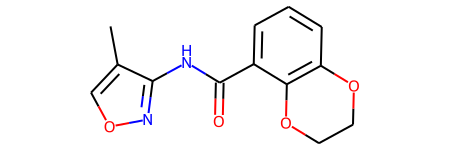

In [14]:
z = torch.randn(1, 56//2)
smiles = model.decode(z, z, False)
print('Random Smile: ', smiles)
Chem.MolFromSmiles(smiles)